<a href="https://colab.research.google.com/github/rohitamar/IdentifyingCarBrandsNoisyImagesCNN/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Car Brands In Noisy Images using Convolutional Neural Networks
Authors: Rohit Amarnath, Mugdhesh Pandkar, Aravind Kumar

# Handle initial imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
import tensorflow as tf
import random
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split

Mount google drive

In [3]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')
PATH_TO_TRAIN_DATASET = 'gdrive/MyDrive/StanfordCarsDataset/car_data/car_data/train'
PATH_TO_TEST_DATASET = 'gdrive/MyDrive/StanfordCarsDataset/car_data/car_data/test'
train_dataset = torchvision.datasets.ImageFolder(PATH_TO_TRAIN_DATASET)
test_dataset = torchvision.datasets.ImageFolder(PATH_TO_TEST_DATASET)

Mounted at /content/gdrive


Verify Device

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

# empty cache
torch.cuda.empty_cache()

using device: cuda:0


Data Loading Parameters

In [5]:
m = len(train_dataset)
print("size of dataset: " + str(m))

train_size = int(m - m * 0.2)
val_size = m - train_size
batch_size = 32

# noise


# train_data, validation_data = random_split(train_dataset, [train_size, val_size])

# train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
# validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size)

# print(len(train_loader))
# print(len(validation_loader))

size of dataset: 8144


AutoEncoder Architecture

In [6]:
class AutoEncoder(nn.Module):    
    def __init__(self, device):
        super().__init__()
        self.encoder = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size = 5),
          nn.ReLU(True),
          nn.Conv2d(16, 32, kernel_size = 5),
          nn.ReLU(True),
          nn.Conv2d(32, 64, kernel_size = 5),
          nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 5),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size = 5),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size = 5),
            nn.ReLU(True)
        )
        self.device=device
    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

Hyperparameters

In [7]:
weight_decay = 1e-5
learning_rate = 1e-3

Noise Function

In [8]:
def add_noise(image_batch_inputs, noise_factor = 0.12):
  noisy_batch = image_batch_inputs + torch.randn_like(image_batch_inputs) * noise_factor
  noisy_batch = torch.clip(noisy_batch,0.,1.)
  return noisy_batch

In [9]:
def add_blur(image_batch_inputs, kernel_size=199):
  transform = transforms.Compose([transforms.GaussianBlur(kernel_size = (7, 11), sigma = (11, 11)), ])
  blurry_batch = transform(image_batch_inputs)
  return blurry_batch

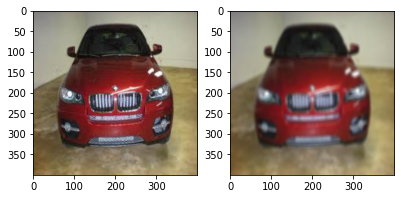

In [10]:
# for visualization purposes
import cv2
from random import randint

def visualize_blur():
  visualize_data = train_dataset
  visualize_transform = transforms.Compose([transforms.Resize((400, 400)), transforms.ToTensor()])
  visualize_data.transform = visualize_transform
  visualize_loader = torch.utils.data.DataLoader(visualize_data, batch_size = batch_size, shuffle = True)

  dataiter = iter(visualize_loader)
  images, labels = dataiter.next()

  index = randint(0,len(images))
  image = images[index].permute(1,2,0)
  fig = plt.figure(figsize = (10, 7))
  fig.add_subplot(2, 3, 1)
  plt.imshow(image)

  blurry = add_blur(images)
  fig.add_subplot(2, 3, 2)
  plt.imshow(blurry[index].permute(1,2,0))


visualize_blur()

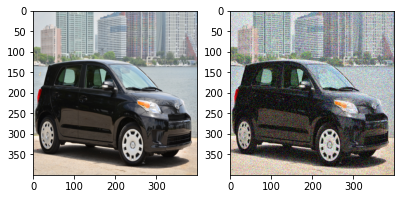

In [11]:
# for visualization purposes
import cv2
from random import randint

def visualize_noise():
  visualize_data = train_dataset
  visualize_transform = transforms.Compose([transforms.Resize((400, 400)), transforms.ToTensor()])
  visualize_data.transform = visualize_transform
  visualize_loader = torch.utils.data.DataLoader(visualize_data, batch_size = batch_size, shuffle = True)

  dataiter = iter(visualize_loader)
  images, labels = dataiter.next()

  index = randint(0,len(images))
  image = images[index].permute(1,2,0)
  fig = plt.figure(figsize = (10, 7))
  fig.add_subplot(2, 3, 1)
  plt.imshow(image)

  noisy = add_noise(images, 0.12)
  fig.add_subplot(2, 3, 2)
  plt.imshow(noisy[index].permute(1,2,0))


visualize_noise()

Deblurring model

In [12]:
# blurring
train_transform = transforms.Compose([ transforms.Resize((200, 200)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])
blur_train_dataset = train_dataset
blur_train_dataset.transform = train_transform
blur_train_data, blur_validation_data = random_split(blur_train_dataset, [train_size, val_size])
blur_train_loader = torch.utils.data.DataLoader(blur_train_data, batch_size=batch_size)
blur_validation_loader = torch.utils.data.DataLoader(blur_validation_data, batch_size=batch_size)
blur_test_dataset = test_dataset
test_transform = transforms.Compose([ transforms.Resize((200, 200)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])
blur_test_dataset.transform = test_transform
blur_test_loader = torch.utils.data.DataLoader(blur_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
blur_model = AutoEncoder(device)
blur_model = blur_model.to(device)
blur_model_parameters = blur_model.parameters()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(blur_model_parameters, lr=learning_rate, weight_decay=weight_decay)

In [ ]:
num_epochs = 15
iterations_training_loss = []
epochs_training_loss = []

for epoch in range(num_epochs):
    print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))  
    iteration = 0
    for data in blur_train_loader:
        data = [image.to(device) for image in data]
        iteration = iteration + 1
        img, _ = data
        blurry_images = add_blur(img)
        output = blur_model(blurry_images)
        loss = distance(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Epoch [{}/{}], Iteration: {}, Loss: {:.4f}'.format(epoch + 1, num_epochs, iteration, loss.item()))
        iterations_training_loss.append(loss.item())

Epoch [1/15]
Epoch [1/15], Iteration: 1, Loss: 0.3832
Epoch [1/15], Iteration: 2, Loss: 0.3748
Epoch [1/15], Iteration: 3, Loss: 0.3074
Epoch [1/15], Iteration: 4, Loss: 0.2826
Epoch [1/15], Iteration: 5, Loss: 0.2497
Epoch [1/15], Iteration: 6, Loss: 0.2817
Epoch [1/15], Iteration: 7, Loss: 0.2768
Epoch [1/15], Iteration: 8, Loss: 0.2687
Epoch [1/15], Iteration: 9, Loss: 0.2570
Epoch [1/15], Iteration: 10, Loss: 0.2353
Epoch [1/15], Iteration: 11, Loss: 0.2709
Epoch [1/15], Iteration: 12, Loss: 0.2349
Epoch [1/15], Iteration: 13, Loss: 0.2328
Epoch [1/15], Iteration: 14, Loss: 0.2358
Epoch [1/15], Iteration: 15, Loss: 0.2609
Epoch [1/15], Iteration: 16, Loss: 0.2324
Epoch [1/15], Iteration: 17, Loss: 0.2454
Epoch [1/15], Iteration: 18, Loss: 0.2273
Epoch [1/15], Iteration: 19, Loss: 0.2661
Epoch [1/15], Iteration: 20, Loss: 0.2406
Epoch [1/15], Iteration: 21, Loss: 0.2338
Epoch [1/15], Iteration: 22, Loss: 0.2308
Epoch [1/15], Iteration: 23, Loss: 0.1987
Epoch [1/15], Iteration: 24, L

In [ ]:
filepath = 'gdrive/MyDrive/StanfordCarsDataset/blur_model.pt'
torch.save(blur_model.state_dict(), filepath)

Evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
)

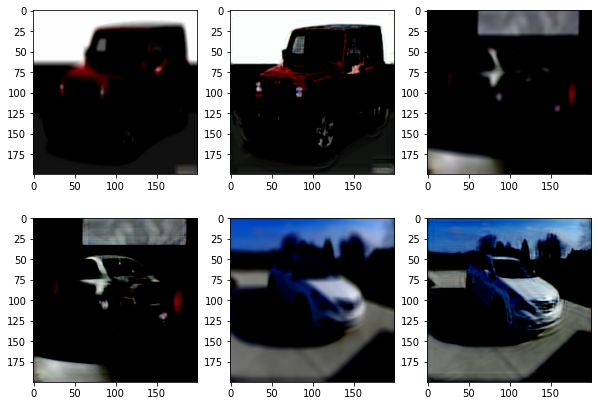

In [30]:
# retrieve stored model
blur_model = AutoEncoder(device)
blur_model = blur_model.to(device)
# blur_model_parameters = blur_model.parameters()
# distance = nn.MSELoss()
# optimizer = torch.optim.Adam(blur_model_parameters, lr=learning_rate, weight_decay=weight_decay)

blur_model.load_state_dict(torch.load('gdrive/MyDrive/StanfordCarsDataset/blur_model.pt'))

# switch model to evaluation mode
blur_model.eval()

with torch.no_grad():
  dataiter = iter(blur_test_loader)
  images, _ = dataiter.next()

  images = images.to(device)


  blurry = add_blur(images)


  rec2 = blur_model(blurry)
  rec2 = rec2.detach()
  rec2 = rec2.cpu()
  blurry = blurry.cpu()


  fig = plt.figure(figsize = (10, 7))
  fig.add_subplot(2, 3, 1)
  plt.imshow(blurry[3].cpu().permute(1,2,0))
  fig.add_subplot(2,3,2)
  plt.imshow(rec2[3].cpu().permute(1,2,0))
  fig.add_subplot(2, 3, 3)
  plt.imshow(blurry[5].cpu().permute(1,2,0))
  fig.add_subplot(2,3,4)
  plt.imshow(rec2[5].permute(1,2,0))
  fig.add_subplot(2, 3, 5)
  plt.imshow(blurry[7].cpu().permute(1,2,0))
  fig.add_subplot(2,3,6)
  plt.imshow(rec2[7].permute(1,2,0))
# switch model to train
blur_model.train()

Denoising model

In [13]:
# denoising
train_transform = transforms.Compose([ transforms.Resize((200, 200)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])
noise_train_dataset = train_dataset
noise_train_dataset.transform = train_transform
noise_train_data, noise_validation_data = random_split(noise_train_dataset, [train_size, val_size])
noise_train_loader = torch.utils.data.DataLoader(noise_train_data, batch_size=batch_size)
noise_validation_loader = torch.utils.data.DataLoader(noise_validation_data, batch_size=batch_size)
noise_test_dataset = test_dataset
test_transform = transforms.Compose([ transforms.Resize((200, 200)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])
noise_test_dataset.transform = test_transform
noise_test_loader = torch.utils.data.DataLoader(noise_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
noise_model = AutoEncoder(device)
noise_model = noise_model.to(device)
noise_model_parameters = noise_model.parameters()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(noise_model_parameters, lr=learning_rate, weight_decay=weight_decay)

In [ ]:
num_epochs = 15
iterations_training_loss = []
epochs_training_loss = []

for epoch in range(num_epochs):
    print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))  
    iteration = 0
    for data in noise_train_loader:
        data = [image.to(device) for image in data]
        iteration = iteration + 1
        img, _ = data
        noisy_images = add_noise(img)
        output = noise_model(noisy_images)
        loss = distance(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Epoch [{}/{}], Iteration: {}, Loss: {:.4f}'.format(epoch + 1, num_epochs, iteration, loss.item()))
        iterations_training_loss.append(loss.item())

Epoch [1/15]
Epoch [1/15], Iteration: 1, Loss: 0.2997
Epoch [1/15], Iteration: 2, Loss: 0.2575
Epoch [1/15], Iteration: 3, Loss: 0.2554
Epoch [1/15], Iteration: 4, Loss: 0.3035
Epoch [1/15], Iteration: 5, Loss: 0.2642
Epoch [1/15], Iteration: 6, Loss: 0.2587
Epoch [1/15], Iteration: 7, Loss: 0.2476
Epoch [1/15], Iteration: 8, Loss: 0.2242
Epoch [1/15], Iteration: 9, Loss: 0.2579
Epoch [1/15], Iteration: 10, Loss: 0.2562
Epoch [1/15], Iteration: 11, Loss: 0.2330
Epoch [1/15], Iteration: 12, Loss: 0.2294
Epoch [1/15], Iteration: 13, Loss: 0.2601
Epoch [1/15], Iteration: 14, Loss: 0.2809
Epoch [1/15], Iteration: 15, Loss: 0.2398
Epoch [1/15], Iteration: 16, Loss: 0.2634
Epoch [1/15], Iteration: 17, Loss: 0.2361
Epoch [1/15], Iteration: 18, Loss: 0.2780
Epoch [1/15], Iteration: 19, Loss: 0.2455
Epoch [1/15], Iteration: 20, Loss: 0.2659
Epoch [1/15], Iteration: 21, Loss: 0.2125
Epoch [1/15], Iteration: 22, Loss: 0.2220
Epoch [1/15], Iteration: 23, Loss: 0.2338
Epoch [1/15], Iteration: 24, L

In [ ]:
filepath = 'gdrive/MyDrive/StanfordCarsDataset/noise_model.pt'
torch.save(noise_model.state_dict(), filepath)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
)

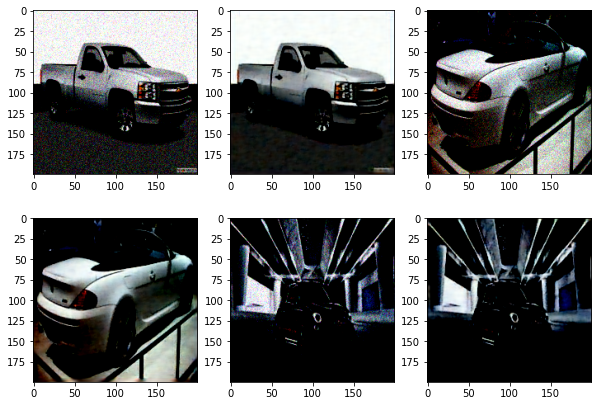

In [31]:
noise_model = AutoEncoder(device)
noise_model = noise_model.to(device)
# blur_model_parameters = blur_model.parameters()
# distance = nn.MSELoss()
# optimizer = torch.optim.Adam(blur_model_parameters, lr=learning_rate, weight_decay=weight_decay)

noise_model.load_state_dict(torch.load('gdrive/MyDrive/StanfordCarsDataset/noise_model.pt'))
# print(test_noise_model.state_dict())

# switch model to evaluation mode
noise_model.eval()

with torch.no_grad():

  dataiter = iter(noise_test_loader)
  images, _ = dataiter.next()

  images = images.to(device)

  noisy = add_noise(images, 0.12)


  rec2 = noise_model(noisy)
  rec2 = rec2.detach()
  rec2 = rec2.cpu()
  noisy = noisy.cpu()


  fig = plt.figure(figsize = (10, 7))
  fig.add_subplot(2, 3, 1)
  plt.imshow(noisy[3].permute(1,2,0))
  fig.add_subplot(2,3,2)
  plt.imshow(rec2[3].permute(1,2,0))
  fig.add_subplot(2, 3, 3)
  plt.imshow(noisy[5].permute(1,2,0))
  fig.add_subplot(2,3,4)
  plt.imshow(rec2[5].permute(1,2,0))
  fig.add_subplot(2, 3, 5)
  plt.imshow(noisy[7].permute(1,2,0))
  fig.add_subplot(2,3,6)
  plt.imshow(rec2[7].permute(1,2,0))

noise_model.train()

# ResNet #

Handle imports

In [14]:
import time
import os
import PIL.Image as Image
from IPython.display import display
import torchvision.models as models


In [41]:
dataset_dir = "gdrive/MyDrive/StanfordCarsDataset/car_data/car_data"

train_tfms = transforms.Compose([transforms.Resize((200, 200)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"/train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"/test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)


Train model function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # evaluate model & switch to eval
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # switch to training
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

    

Evaluation model function

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = resnet_model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

Load ResNet model

In [42]:
resnet_model = models.resnet34(pretrained=True)
num_features = resnet_model.fc.in_features

# replaced last fc layer with a Linear layer of 196 out features (196 classes of cars)
resnet_model.fc = nn.Linear(num_features, 196)
resnet_model = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Training ResNet

In [ ]:
resnet_model, training_losses, training_accs, test_accs = train_model(resnet_model, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 97 s, loss: 3.2090, acc: 22.0956
Accuracy of the network on the test images: 27 %
Epoch 2, duration: 93 s, loss: 1.8789, acc: 48.5172
Accuracy of the network on the test images: 38 %
Epoch 3, duration: 94 s, loss: 1.2720, acc: 63.3211
Accuracy of the network on the test images: 56 %
Epoch 4, duration: 94 s, loss: 0.9568, acc: 71.3848
Accuracy of the network on the test images: 56 %
Epoch 5, duration: 93 s, loss: 0.7411, acc: 77.3897
Accuracy of the network on the test images: 58 %
Epoch 6, duration: 93 s, loss: 0.5664, acc: 82.3284
Accuracy of the network on the test images: 57 %
Epoch 7, duration: 93 s, loss: 0.4155, acc: 87.2426
Accuracy of the network on the test images: 67 %
Epoch 8, duration: 93 s, loss: 0.1960, acc: 94.3015
Accuracy of the network on the test images: 81 %
Epoch 9, duration: 92 s, loss: 0.1148, acc: 97.1446
Accuracy of the network on the test images: 82 %
Epoch 10, duration: 93 s, loss: 0.0909, acc: 97.8554
Accuracy of the network on the test im

Save ResNet

In [ ]:
torch.save(resnet_model.state_dict(), 'gdrive/MyDrive/StanfordCarsDataset/200classifier_model.pt')

In [62]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"/train")

Test ResNet

In [43]:
resnet_model.load_state_dict(torch.load('gdrive/MyDrive/StanfordCarsDataset/200classifier_model.pt'))

resnet_model.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image = Image.open(dataset_dir+"/test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = Image.open(dataset_dir+"/test/Toyota Camry Sedan 2012/00095.jpg")

image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = resnet_model(image)
conf, predicted = torch.max(output.data, 1)

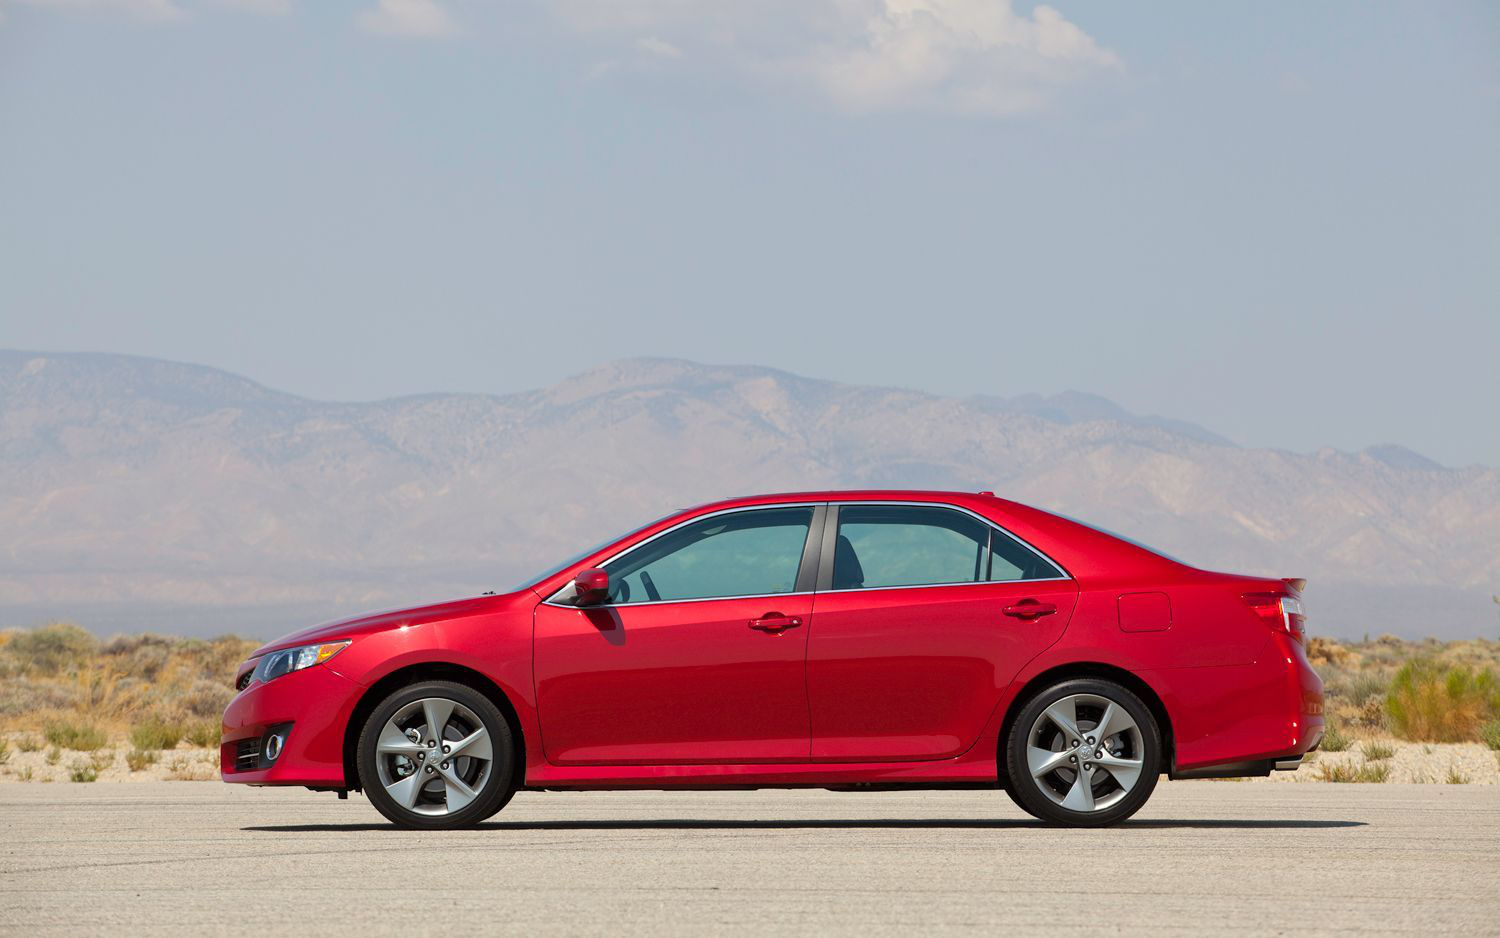

Toyota Camry Sedan 2012 confidence:  11.275237083435059


In [ ]:
#display(Image.open(dataset_dir+"/test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
display(Image.open(dataset_dir+"/test/Toyota Camry Sedan 2012/00095.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

# Linking deblur & denoise to ResNet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17
Rolls-Royce Phantom Sedan 2012
Deblur: Rolls-Royce Phantom Sedan 2012 confidence:  11.169106483459473
Denoise: Rolls-Royce Phantom Sedan 2012 confidence:  12.974181175231934


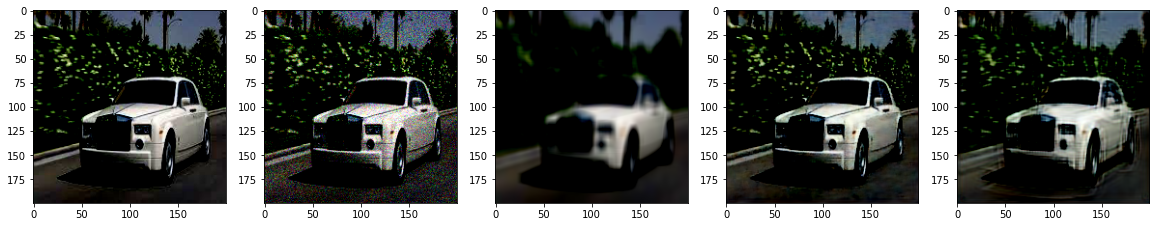

In [81]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



noise_model.load_state_dict(torch.load('gdrive/MyDrive/StanfordCarsDataset/noise_model.pt'))
blur_model.load_state_dict(torch.load('gdrive/MyDrive/StanfordCarsDataset/blur_model.pt'))

noise_model.eval()
blur_model.eval()


with torch.no_grad():
  dataiter = iter(test_loader)
  images, labels = dataiter.next()

  index = randint(0,len(images))
  images = images.to(device)
  noisy = add_noise(images)
  blurry = add_blur(images)
  
  print(index)
  print(classes[labels[index]])

  image = images[index]
  noise_image = noisy[index]
  blur_image = blurry[index]
  denoise_image = noise_model(noise_image)
  deblur_image = blur_model(blur_image)


  fig = plt.figure(figsize = (20, 10))
  fig.add_subplot(1, 5, 1)
  plt.imshow(image.cpu().permute(1,2,0))
  fig.add_subplot(1, 5, 2)
  plt.imshow(noise_image.cpu().permute(1,2,0))
  fig.add_subplot(1, 5, 3)
  plt.imshow(blur_image.cpu().permute(1,2,0))
  fig.add_subplot(1, 5, 4)
  plt.imshow(denoise_image.detach().cpu().permute(1,2,0))
  fig.add_subplot(1, 5, 5)
  plt.imshow(deblur_image.detach().cpu().permute(1,2,0))

  deblur_image = deblur_image.unsqueeze(0)
  deblur_output = resnet_model(deblur_image)
  conf, predicted = torch.max(deblur_output.data, 1)
  print("Deblur: " + classes[predicted.item()], "confidence: ", conf.item())

  denoise_image = denoise_image.unsqueeze(0)
  denoise_output = resnet_model(denoise_image)
  conf, predicted = torch.max(denoise_output.data, 1)
  print("Denoise: " + classes[predicted.item()], "confidence: ", conf.item())

# output = resnet_model(image)

